# **UTS PE**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# assumptions
## kolmogorov-smirnov test
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import acorr_ljungbox

Metrics Template:

In [3]:
def metrics(y_test, X_test, model):
    """
    Menghitung evaluasi model regresi: R-squared, Adjusted R-squared, Log-Likelihood, AIC, dan BIC.

    Parameters:
    - y_test: Array-like, nilai aktual dari variabel dependen
    - X_test: DataFrame, variabel independen untuk data uji
    - model: Hasil regresi dari statsmodels (model.fit())

    Returns:
    - DataFrame dengan nilai R², Adjusted R², Log-Likelihood, AIC, dan BIC.
    """
    from sklearn.metrics import r2_score
    import numpy as np
    import pandas as pd

    # Prediksi nilai dari model
    y_pred = model.predict(X_test)

    # Hitung R-squared (R²)
    r2 = r2_score(y_test, y_pred)

    # Hitung Adjusted R²
    n = X_test.shape[0]  # Jumlah observasia
    p = X_test.shape[1]  # Jumlah prediktor
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Hitung Log-Likelihood (LL)
    residuals = y_test - y_pred
    sse = np.sum(residuals ** 2)  # Sum of Squared Errors
    sigma2 = sse / n  # Estimasi varians residual
    ll = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)

    # Hitung AIC dan BIC
    aic = 2 * (p + 1) - 2 * ll  # AIC formula: 2k - 2LL (k = jumlah parameter)
    bic = np.log(n) * (p + 1) - 2 * ll  # BIC formula: ln(n) * k - 2LL

    # Buat DataFrame hasil evaluasi
    metrics_dict = {
        "R-squared": r2,
        "Adjusted R-squared": adj_r2,
        "Log-Likelihood": ll,
        "AIC": aic,
        "BIC": bic
    }
    metrics_df = pd.DataFrame(metrics_dict, index=[0])

    return metrics_df

Assumption Template:

In [4]:
from scipy.stats import kstest
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox

def test_assumptions(residuals, X_train):
    """
    Test assumptions of normality, homoskedasticity, and no-autocorrelation.

    Parameters:
    - residuals: Residuals from the regression model.
    - X_train: Training data for independent variables.

    Returns:
    - DataFrame with columns: Assumption, Statistics, p-value, and Conclusion.
    """

    # Normality Test (Kolmogorov-Smirnov)
    ks_statistic, ks_pvalue = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
    ks_conclusion = "Fail to Reject H0 (Normal)" if ks_pvalue > 0.05 else "Reject H0 (Not Normal)"

    # Homoskedasticity Test (Breusch-Pagan)
    bp_statistic, bp_pvalue, _, _ = het_breuschpagan(residuals, X_train)
    bp_conclusion = "Fail to Reject H0 (Homoskedastic)" if bp_pvalue > 0.05 else "Reject H0 (Heteroskedastic)"

    # No-Autocorrelation Test (Ljung-Box) up to 10 lags
    lb_results = acorr_ljungbox(residuals, lags=10, return_df=True)
    
    # Extract statistics and p-values for each lag
    lb_statistics = lb_results['lb_stat'].tolist()  # lb_stat is the Ljung-Box statistic for each lag
    lb_pvalues = lb_results['lb_pvalue'].tolist()  # lb_pvalue is the p-value for each lag

    # Build the conclusion for autocorrelation test
    autocorrelation_lags = [lag + 1 for lag, pval in enumerate(lb_pvalues) if pval <= 0.05]
    if autocorrelation_lags:
        lb_conclusion = f"Autocorrelation exists at lag {', '.join(map(str, autocorrelation_lags))}"
    else:
        lb_conclusion = "No Autocorrelation up to lag 10"

    # Create DataFrame
    results = pd.DataFrame({
        "Assumption": ["Normality", "Homoskedasticity", "No Autocorrelation"],
        "Statistics": [ks_statistic, bp_statistic, lb_statistics],
        "p-value": [ks_pvalue, bp_pvalue, lb_pvalues],
        "Conclusion": [ks_conclusion, bp_conclusion, lb_conclusion]
    })

    return results

## Import Data

In [49]:
data = pd.read_excel('data uts.xlsx', sheet_name='Sheet1')
data.head()

,Tahun,Jumlah Angkatan Kerja 15-64,GCF (US current),PDB (USD current),Unnamed: 4,Unnamed: 5,Gross Capital Form (LCU current),PDB (LCU constant),PDB (USD constant 2015)
0,1960,NaN,NaN,NaN,NaN,NaN,30700000000,5.507040e+19,5.277761e+10
1,1961,NaN,NaN,NaN,NaN,NaN,48110000000,5.823180e+19,5.580738e+10
2,1962,NaN,NaN,NaN,NaN,NaN,74800000000,5.930440e+19,5.683534e+10
3,1963,NaN,NaN,NaN,NaN,NaN,2.63E+11,5.797770e+19,5.556392e+10
4,1964,NaN,NaN,NaN,NaN,NaN,8.62E+11,6.002420e+19,5.752516e+10


In [50]:
data = data[data['Tahun'] >= 1990]
data.head()

,Tahun,Jumlah Angkatan Kerja 15-64,GCF (US current),PDB (USD current),Unnamed: 4,Unnamed: 5,Gross Capital Form (LCU current),PDB (LCU constant),PDB (USD constant 2015)
30,1990,7.506550e+07,3.471618e+10,1.061410e+16,NaN,NaN,6397530000000000000,2.816410e+20,2.699150e+16
31,1991,7.661831e+07,3.716676e+10,1.166220e+16,NaN,NaN,7248710000000000000,3.011080e+20,2.885720e+16
32,1992,7.884130e+07,3.863320e+10,1.280270e+16,NaN,NaN,7842230000000000000,3.206720e+20,3.073220e+16
33,1993,7.995024e+07,4.468536e+10,1.580070e+16,NaN,NaN,9326280000000000000,3.415040e+20,3.272860e+16
34,1994,8.357638e+07,5.230822e+10,1.768920e+16,NaN,NaN,11302500000000000000,3.672540e+20,3.519640e+16


In [51]:
data = data[['Tahun', 'Jumlah Angkatan Kerja 15-64', 'GCF (US current)', 'PDB (USD constant 2015)']]
data.head()

,Tahun,Jumlah Angkatan Kerja 15-64,GCF (US current),PDB (USD constant 2015)
30,1990,7.506550e+07,3.471618e+10,2.699150e+16
31,1991,7.661831e+07,3.716676e+10,2.885720e+16
32,1992,7.884130e+07,3.863320e+10,3.073220e+16
33,1993,7.995024e+07,4.468536e+10,3.272860e+16
34,1994,8.357638e+07,5.230822e+10,3.519640e+16


In [52]:
data.reset_index(drop=True, inplace=True)

## Menambahkan Data Tahun 2024

In [54]:
data.rename(columns={'Tahun': 'Year',
                     'Jumlah Angkatan Kerja 15-64': 'AK',
                     'GCF (US current)': 'Modal',
                     'PDB (USD constant 2015)': 'PDB'}, inplace=True)

In [82]:
# Forecast 2024
data_2024 = data.copy()

# Add a row
data_2024.reset_index(drop=True, inplace=True)

# Moving Average
data_2024.loc[len(data_2024)-1, 'AK'] = data_2024['AK'].iloc[-3:].mean()
data_2024.loc[len(data_2024)-1, 'Modal'] = data_2024['Modal'].iloc[-3:].mean()
data_2024.loc[len(data_2024)-1, 'PDB'] = data_2024['PDB'].iloc[-3:].mean()

In [83]:
data_2024

,Year,AK,Modal,PDB
0,1990,7.506550e+07,3.471618e+10,2.699150e+16
1,1991,7.661831e+07,3.716676e+10,2.885720e+16
2,1992,7.884130e+07,3.863320e+10,3.073220e+16
3,1993,7.995024e+07,4.468536e+10,3.272860e+16
4,1994,8.357638e+07,5.230822e+10,3.519640e+16
5,1995,8.554124e+07,6.150839e+10,3.808950e+16
6,1996,8.749537e+07,7.185419e+10,4.106740e+16
7,1997,8.868854e+07,6.538851e+10,4.299750e+16
8,1998,9.144248e+07,2.618024e+10,3.735340e+16
9,1999,9.394726e+07,3.099456e+10,3.764890e+16


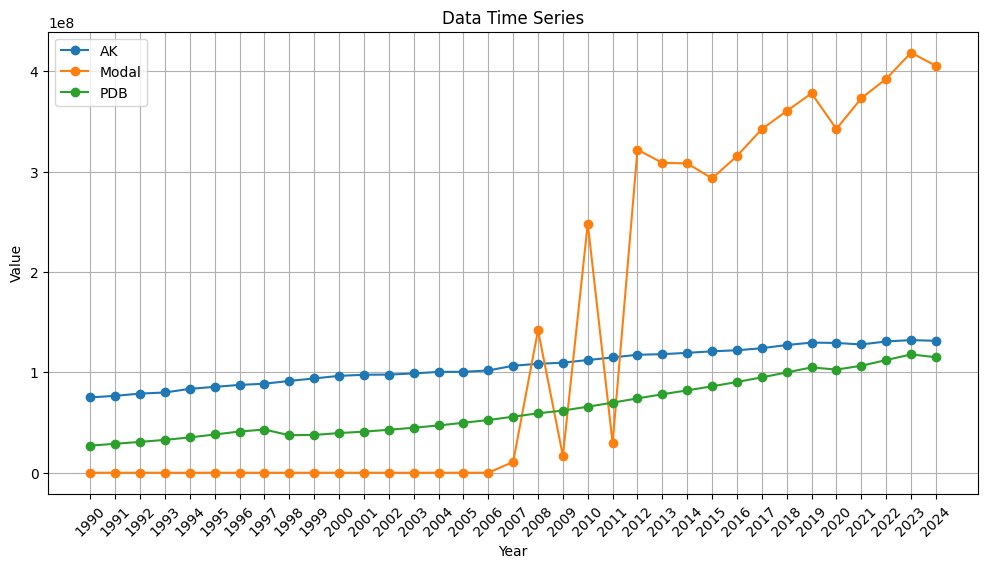

In [84]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data_2024['Year'], data_2024['AK'], marker='o', label='AK')
plt.plot(data_2024['Year'], data_2024['Modal']/100000000, marker='o', label='Modal')
plt.plot(data_2024['Year'], data_2024['PDB']/1000000000, marker='o', label='PDB')
plt.title('Data Time Series')
plt.xlabel('Year') # Show all years
plt.xticks(data_2024['Year'], rotation=45)
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

## Model Regresi

In [85]:
# Regression model
formula = 'np.log(PDB) ~ np.log(Modal) + np.log(AK)'
model = smf.ols(formula=formula, data=data_2024).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(PDB)   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     468.9
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.97e-24
Time:                        14:11:52   Log-Likelihood:                 38.206
No. Observations:                  35   AIC:                            -70.41
Df Residuals:                      32   BIC:                            -65.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1252      3.305      0.038

In [86]:
test_assumptions(model.resid, data_2024[['AK', 'Modal']].assign(const=1))

,Assumption,Statistics,p-value,Conclusion
0,Normality,0.135468,0.499325,Fail to Reject H0 (Normal)
1,Homoskedasticity,0.522069,0.770254,Fail to Reject H0 (Homoskedastic)
2,No Autocorrelation,"[22.733076801650792, 33.172100606781505, 37.27...","[1.8613614539869843e-06, 6.262819233754586e-08...","Autocorrelation exists at lag 1, 2, 3, 4, 5, 6..."


In [87]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data_2024[['Modal', 'AK']]  # Kolom variabel independen
X = np.log(X)  # Mengambil log dari variabel independen

# Menambahkan konstanta untuk menghitung VIF
X = sm.add_constant(X)

# Menghitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Menampilkan hasil VIF
print(vif_data)


  Variable           VIF
0    const  52965.232668
1    Modal      4.931031
2       AK      4.931031


## Penanganan Asumsi

### Penambahan Prediktor $Y_{t-1}$.

In [88]:
# Penanganan asumsi autokorelasi
## Menggunakan lag 1 dari variabel dependen

data_2024['PDB_lag1'] = data_2024['PDB'].shift(1)
data_2024.dropna(inplace=True)
data_2024.reset_index(drop=True, inplace=True)
data_2024.head()

,Year,AK,Modal,PDB,PDB_lag1
0,1991,7.661831e+07,3.716676e+10,2.885720e+16,2.699150e+16
1,1992,7.884130e+07,3.863320e+10,3.073220e+16,2.885720e+16
2,1993,7.995024e+07,4.468536e+10,3.272860e+16,3.073220e+16
3,1994,8.357638e+07,5.230822e+10,3.519640e+16,3.272860e+16
4,1995,8.554124e+07,6.150839e+10,3.808950e+16,3.519640e+16


In [89]:
# Regression model with lagged dependent variable
formula = 'np.log(PDB) ~ np.log(Modal) + np.log(AK) + np.log(PDB_lag1)'

model = smf.ols(formula=formula, data=data_2024).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(PDB)   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1571.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.62e-33
Time:                        14:11:58   Log-Likelihood:                 66.246
No. Observations:                  34   AIC:                            -124.5
Df Residuals:                      30   BIC:                            -118.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.6009      1.567  

In [90]:
test_assumptions(model.resid, data_2024[['AK', 'Modal', 'PDB_lag1']].assign(const=1))

,Assumption,Statistics,p-value,Conclusion
0,Normality,0.179149,0.199561,Fail to Reject H0 (Normal)
1,Homoskedasticity,1.078649,0.782231,Fail to Reject H0 (Homoskedastic)
2,No Autocorrelation,"[1.3619214939807254, 2.220876076340813, 3.4618...","[0.24320474735182213, 0.32941463328368725, 0.3...",No Autocorrelation up to lag 10


In [93]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data_2024[['Modal', 'AK', 'PDB_lag1']]  # Kolom variabel independen
X = np.log(X)  # Mengambil log dari variabel independen

# Menambahkan konstanta untuk menghitung VIF
X = sm.add_constant(X)

# Menghitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Menampilkan hasil VIF
print(vif_data)

   Variable           VIF
0     const  61940.443175
1     Modal      5.730796
2        AK     23.133506
3  PDB_lag1     25.462932


Terdapat multikolinearitas pada Angkatan Kerja. Akan dibangun model tanpa angkatan kerja.

In [100]:
# Mean log pdb
mean_log_pdb = np.mean(np.log(data_2024['PDB']))
print(mean_log_pdb)

# Standard deviation log pdb
std_log_pdb = np.std(np.log(data_2024['PDB']))
print(std_log_pdb)

38.6243866810138
0.4335886790662375


In [104]:
# Regression model with lagged dependent variable
formula = 'np.log(PDB) ~ np.log(Modal) + np.log(PDB_lag1)'

model = smf.ols(formula=formula, data=data_2024).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(PDB)   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2388.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.11e-34
Time:                        14:16:52   Log-Likelihood:                 65.917
No. Observations:                  34   AIC:                            -125.8
Df Residuals:                      31   BIC:                            -121.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.3201      1.245  

In [105]:
test_assumptions(model.resid, data_2024[['Modal', 'PDB_lag1']].assign(const=1))

,Assumption,Statistics,p-value,Conclusion
0,Normality,0.232048,0.043039,Reject H0 (Not Normal)
1,Homoskedasticity,0.987023,0.610479,Fail to Reject H0 (Homoskedastic)
2,No Autocorrelation,"[1.0298644628409577, 2.3205338716731014, 3.743...","[0.3101905035737619, 0.3134025113543589, 0.290...",No Autocorrelation up to lag 10


In [ ]:
# VIF
X = data_2024[['Modal', 'PDB_lag1']]  # Kolom variabel independen
X = np.log(X)  # Mengambil log dari variabel independen

# Menambahkan konstanta untuk menghitung VIF
X = sm.add_constant(X)

# Menghitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Menampilkan hasil VIF
print(vif_data)

   Variable           VIF
0     const  39650.446318
1     Modal      5.653411
2  PDB_lag1      5.653411


### Transformasi Box-Cox pada $Y$.

Metode transformasi box-cox:

In [106]:
data_2024['log_PDB'] = np.log(data_2024['PDB'])
data_2024['log_AK'] = np.log(data_2024['AK'])
data_2024['log_Modal'] = np.log(data_2024['Modal'])
data_2024['log_PDB_lag1'] = np.log(data_2024['PDB_lag1'])

# Transformasi boxcox pada log_PDB
from scipy import stats
from scipy.stats import boxcox

# Box-Cox transformation
data_2024['boxcox_PDB'] = boxcox(data_2024['PDB'])[0]
lam = boxcox(data_2024['PDB'])[1]

print(lam)

-0.14856710864658876


In [110]:
# Regression model with boxcox transformation
formula = 'boxcox_PDB ~ log_Modal + log_PDB_lag1'
model = smf.ols(formula=formula, data=data_2024).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             boxcox_PDB   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2094.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           8.45e-34
Time:                        14:22:47   Log-Likelihood:                 258.84
No. Observations:                  34   AIC:                            -511.7
Df Residuals:                      31   BIC:                            -507.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.5970      0.004   1543.330   

In [111]:
test_assumptions(model.resid, data_2024[['log_AK', 'log_Modal', 'log_PDB_lag1']].assign(const=1))

,Assumption,Statistics,p-value,Conclusion
0,Normality,0.234641,0.039507,Reject H0 (Not Normal)
1,Homoskedasticity,5.440912,0.142216,Fail to Reject H0 (Homoskedastic)
2,No Autocorrelation,"[1.6938079583363852, 2.3415775486590293, 3.276...","[0.1930997561689028, 0.31012222831381975, 0.35...",No Autocorrelation up to lag 10


In [113]:
# multicollinearity
X = data_2024[['log_Modal', 'log_PDB_lag1']]  # Kolom variabel independen
X = np.log(X)  # Mengambil log dari variabel independen

# Menambahkan konstanta untuk menghitung VIF
X = sm.add_constant(X)

# Menghitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Menampilkan hasil VIF
print(vif_data)

       Variable            VIF
0         const  517672.019108
1     log_Modal       5.476245
2  log_PDB_lag1       5.476245


Transformasi boxcox tidak menyelesaikan masalah.

### Metode GLS

In [116]:
import statsmodels.api as sm

# Membentuk model regresi GLS
gls_model = sm.GLS.from_formula('boxcox_PDB ~ log_Modal + log_PDB_lag1', data_2024).fit()

# Menampilkan ringkasan hasil GLS
print(gls_model.summary())


                            GLS Regression Results                            
Dep. Variable:             boxcox_PDB   R-squared:                       0.993
Model:                            GLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2094.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           8.45e-34
Time:                        14:24:46   Log-Likelihood:                 258.84
No. Observations:                  34   AIC:                            -511.7
Df Residuals:                      31   BIC:                            -507.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.5970      0.004   1543.330   

In [117]:
test_assumptions(gls_model.resid, data_2024[['log_AK', 'log_Modal', 'log_PDB_lag1']].assign(const=1))

,Assumption,Statistics,p-value,Conclusion
0,Normality,0.234641,0.039507,Reject H0 (Not Normal)
1,Homoskedasticity,5.440912,0.142216,Fail to Reject H0 (Homoskedastic)
2,No Autocorrelation,"[1.6938079583363852, 2.3415775486590293, 3.276...","[0.1930997561689028, 0.31012222831381975, 0.35...",No Autocorrelation up to lag 10


### Penanganan Outlier

In [150]:
# Regresi Robust
formula = "log_PDB ~ log_Modal + log_PDB_lag1"
robust_model = smf.rlm(formula, data=data_2024, M=sm.robust.norms.TukeyBiweight()).fit()
print(robust_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                log_PDB   No. Observations:                   34
Model:                            RLM   Df Residuals:                       31
Method:                          IRLS   Df Model:                            2
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 09 Apr 2025                                         
Time:                        14:30:52                                         
No. Iterations:                     4                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1319      0.301      3.766   

In [151]:
metrics(data_2024['log_PDB'], data_2024[['log_AK', 'log_Modal', 'log_PDB_lag1']], robust_model)

,R-squared,Adjusted R-squared,Log-Likelihood,AIC,BIC
0,0.992229,0.991452,62.743707,-117.487414,-111.381972


In [152]:
test_assumptions(robust_model.resid, data_2024[['log_AK', 'log_Modal', 'log_PDB_lag1']].assign(const=1))

,Assumption,Statistics,p-value,Conclusion
0,Normality,0.339329,0.000537,Reject H0 (Not Normal)
1,Homoskedasticity,4.2814,0.232638,Fail to Reject H0 (Homoskedastic)
2,No Autocorrelation,"[1.3335680442076896, 1.8862091573613244, 2.287...","[0.24817144963701962, 0.3894169810775458, 0.51...",No Autocorrelation up to lag 10


Apabila outlier dihapuskan:

In [153]:
# Bentuk model awal
formula = 'log_PDB ~ log_AK + log_Modal + log_PDB_lag1'
model = smf.ols(formula=formula, data=data_2024).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_PDB   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1571.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.62e-33
Time:                        14:31:29   Log-Likelihood:                 66.246
No. Observations:                  34   AIC:                            -124.5
Df Residuals:                      30   BIC:                            -118.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6009      1.567      1.660   

In [155]:
# Cook's distance outlier detection
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(model)
cooks_d = influence.cooks_distance

cooks_d_df = pd.DataFrame(cooks_d[0], columns=['Cooks_Distance'])
cooks_d_df['Index'] = influence.resid.index
cooks_d_df['Year'] = data_2024['Year']

outlier_index = cooks_d_df[cooks_d_df['Cooks_Distance'] > 4 / len(data_2024)].index
outlier_index = outlier_index.tolist()
print(outlier_index)

[7]


In [169]:
# Bentuk model regresi tanpa outlier
data_no_outlier = data_2024.drop(outlier_index)
formula = 'log_PDB ~ log_Modal + log_PDB_lag1'
model_no_outlier = smf.ols(formula=formula, data=data_no_outlier).fit(cov_type='HC1')
print(model_no_outlier.summary())

                            OLS Regression Results                            
Dep. Variable:                log_PDB   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7229.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           5.52e-41
Time:                        14:44:29   Log-Likelihood:                 85.914
No. Observations:                  33   AIC:                            -165.8
Df Residuals:                      30   BIC:                            -161.3
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.3374      0.734      3.185   

In [170]:
# Test assumptions
test_assumptions(model_no_outlier.resid, data_no_outlier[['log_Modal', 'log_PDB_lag1']].assign(const=1))

,Assumption,Statistics,p-value,Conclusion
0,Normality,0.185576,0.181382,Fail to Reject H0 (Normal)
1,Homoskedasticity,6.1253,0.046764,Reject H0 (Heteroskedastic)
2,No Autocorrelation,"[0.06725105870596015, 2.681583811175437, 5.634...","[0.795382107198133, 0.2616383936141914, 0.1308...",No Autocorrelation up to lag 10


In [177]:
# White test for heteroskedasticity
from statsmodels.stats.diagnostic import het_white

white_test = het_white(model_no_outlier.resid, model_no_outlier.model.exog)
white_test

(9.968345985961768, 0.07613713303719505, 2.337177707314625, 0.0691706686465652)

In [171]:
# multicollinearity
X = data_no_outlier[['log_Modal', 'log_PDB_lag1']]  # Kolom variabel independen
X = np.log(X)  # Mengambil log dari variabel independen

# Menambahkan konstanta untuk menghitung VIF
X = sm.add_constant(X)

# Menghitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Menampilkan hasil VIF
print(vif_data)

       Variable            VIF
0         const  517498.700730
1     log_Modal       5.579785
2  log_PDB_lag1       5.579785
